In [1]:
# Run in python console
import nltk; nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adaku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
data = pd.read_csv('input_punctuation.csv')

In [4]:
data.head()

,text,class
0,latest headlines on cnn business tl;dr the u.s...,ctrl
1,china wants to take a victory lap over its han...,ctrl
2,coronavirus disinformation creates challenges ...,ctrl
3,china coronavirus: eating wild animals made il...,ctrl
4,china's economy could shrink for the first tim...,ctrl


In [5]:
data['text'][1]

"china wants to take a victory lap over its handling of the coronavirus outbreak in hong kong. the virus has killed at least 21 people and infected more than 1,000 since it was first detected there last month. it is believed that most have been chinese citizens who had traveled abroad for treatment or were working as doctors there. but health officials say they are still investigating whether anyone else may be infected. a total ban on travel from this country remains until further notice. [page a8.] in addition today, china's ministry of health said tests showed evidence suggesting an unusual strain called sars could spread through humans if not properly treated. [excerpts, page b6.] dr. wu jianmin, director general with guangdong province, which includes guangzhou, told reporters today he expected a significant outbreak within days. he added later by telephone that, we're prepared should something happen. at issue here will likely turn out either one way -- another case confirms what

In [6]:
from nltk import tokenize
from nltk.tokenize import word_tokenize, sent_tokenize

In [105]:
token_word = []

for i in data[data['class'] == 'gpt']['text']:
    token_word.append(word_tokenize(i))

In [106]:
data_words = list(token_word)

In [107]:
len(data_words)

1066

In [108]:
data_words[:1]

[['latest',
  'headlines',
  'on',
  'cnn',
  'business.',
  '``',
  'it',
  "'s",
  'a',
  'good',
  'thing',
  'you',
  "'re",
  'not',
  'in',
  'the',
  'news',
  ',',
  'because',
  'i',
  'would',
  'have',
  'had',
  'to',
  'kill',
  'myself',
  'if',
  'that',
  'happened',
  '.',
  'and',
  'now',
  'i',
  "'m",
  'going',
  'home',
  'with',
  'my',
  'wife',
  'and',
  'son',
  'for',
  'christmas',
  'dinner.',
  '``',
  'he',
  'sighed',
  'heavily',
  'as',
  'he',
  'stared',
  'at',
  'his',
  'computer',
  'screen',
  '.',
  'she',
  'knew',
  'what',
  'was',
  'coming',
  'next',
  ';',
  'she',
  "'d",
  'seen',
  'enough',
  'of',
  'this',
  'kind',
  'of',
  'stuff',
  'before',
  'from',
  'her',
  'father',
  '-',
  'or',
  'so',
  'they',
  'said',
  '.',
  'but',
  'she',
  'did',
  "n't",
  'want',
  'him',
  'thinking',
  'about',
  'himself',
  'when',
  'he',
  'got',
  'back',
  'from',
  'new',
  'york',
  '.',
  'he',
  'needed',
  'time',
  'to',
  '

In [109]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['latest', 'headlines', 'on', 'cnn', 'business.', '``', 'it', "'s", 'a', 'good', 'thing', 'you', "'re", 'not', 'in', 'the', 'news', ',', 'because', 'i', 'would', 'have', 'had', 'to', 'kill', 'myself', 'if', 'that', 'happened', '.', 'and', 'now', 'i', "'m", 'going', 'home', 'with', 'my', 'wife', 'and', 'son', 'for', 'christmas', 'dinner.', '``', 'he', 'sighed_heavily', 'as', 'he', 'stared', 'at', 'his', 'computer_screen', '.', 'she', 'knew', 'what', 'was', 'coming', 'next', ';', 'she', "'d", 'seen', 'enough', 'of', 'this', 'kind', 'of', 'stuff', 'before', 'from', 'her', 'father', '-', 'or', 'so', 'they', 'said', '.', 'but', 'she', 'did', "n't", 'want', 'him', 'thinking', 'about', 'himself', 'when', 'he', 'got', 'back', 'from', 'new_york', '.', 'he', 'needed', 'time', 'to', 'think', 'about', 'things', 'like', 'how', 'much', 'money', 'he', 'could', 'spend', 'on', 'clothes', 'and', 'shoes', 'and', 'furniture.', '``', 'dad', '...', 'please', 'do', "n't", 'go', ',', '``', 'she', 'whispered',

In [110]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [111]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [112]:
import spacy
spacy.load("en_core_web_sm")
import en_core_web_sm

# nlp = en_core_web_sm.load()

In [113]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['late', 'headline', 'cnn', 'business', 'good', 'thing', 'news', 'would', 'kill', 'happen', 'go', 'home', 'wife', 'son', 'christmas', 'dinner', 'sighed_heavily', 'stare', 'computer_screen', 'know', 'come', 'next', 'see', 'enough', 'kind', 'stuff', 'father', 'say', 'want', 'thinking', 'get', 'back', 'need', 'time', 'think', 'thing', 'much', 'money', 'could', 'spend', 'clothe', 'shoe', 'furniture', 'dad', 'go', 'whisper', 'turn', 'look', 'old', 'ever', 'tired', 'ask', 'softly', 'feel', 'tear', 'prick', 'eye', 'people', 'need', 'chapter_twenty', 'rachel', 'sit', 'alone', 'kitchen', 'stare', 'dark', 'night', 'trying_desperately', 'figure', 'life', 'go', 'wrong', 'thought', 'may', 'able', 'find', 'work', 'somewhere', 'else', 'maybe', 'even', 'get', 'help', 'remember', 'tell', 'want', 'daughter', 'live', 'welfare', 'payment', 'anymore', 'could', 'barely', 'afford', 'grocery', 'let', 'alone', 'rent', 'car', 'lucky', 'still', 'live', 'force', 'move', 'california', 'cell_phone', 'ring', 'calle

In [114]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 3), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 3), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 2), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [115]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [116]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [117]:
# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [118]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.206852567349173

Coherence Score:  0.48332630496571527


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.299983  0.164514       1        1  26.926580
0     -0.271075 -0.025845       2        1  11.249496
17    -0.165053  0.235908       3        1  10.247264
11    -0.279123  0.014641       4        1   9.815907
6     -0.226775  0.008189       5        1   8.234020
15    -0.191184  0.060513       6        1   7.448478
1     -0.266030 -0.032538       7        1   7.355419
3     -0.197317  0.013802       8        1   7.313837
2     -0.136585 -0.263354       9        1   4.596408
14    -0.050876 -0.320842      10        1   3.212100
12     0.142873 -0.005061      11        1   0.750016
13     0.137658 -0.008348      12        1   0.691838
9      0.151320 -0.036464      13        1   0.580751
16     0.182890  0.001879      14        1   0.477527
19     0.223932  0.031686      15        1   0.377983
4      0.217869  0.025946      16        1   0.291460
7      0.256678  0.034761      17        1   0.148247
8      0.245618  0.028862      18        1   0.136336
18     0.256189  0.034674      19        1   0.104144
10     0.268976  0.037076      20        1   0.042198, topic_info=                   Term          Freq         Total Category  logprob  loglift
138               state  14957.000000  14957.000000  Default  30.0000  30.0000
55           government  14377.000000  14377.000000  Default  29.0000  29.0000
1197            politic  12302.000000  12302.000000  Default  28.0000  28.0000
128                 say  43209.000000  43209.000000  Default  27.0000  27.0000
1215              trump   7675.000000   7675.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
6040               nasa      0.013394      1.051808  Topic20 -11.2029   3.4071
8707   security_council      0.013393      1.051776  Topic20 -11.2029   3.4071
5654               salt      0.013393      1.051795  Topic20 -11.2029   3.4071
18090              gram      0.013393      1.051793  Topic20 -11.2029   3.4071
24615      hide_caption      0.013393      1.051946  Topic20 -11.2029   3.4069

[959 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         1  0.023436         accord
2         2  0.266835         accord
2         4  0.416488         accord
2         5  0.016660         accord
2         6  0.073980         accord
...     ...       ...            ...
174       4  0.363687          yield
174      16  0.623464          yield
958       6  0.999625          young
1566     18  0.989262          youth
4134     17  0.659117  youtube_video

[1429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 18, 12, 7, 16, 2, 4, 3, 15, 13, 14, 10, 17, 20, 5, 8, 9, 19, 11])

# Classifier

In [104]:
coll = []
for i in corpus:
    coll.append( list(sum(i, ())) )


In [162]:
collapsed = pd.DataFrame(coll)
collapsed.fillna(0)

,0,1,2,3,4,5,6,7,8,9,...,4598,4599,4600,4601,4602,4603,4604,4605,4606,4607
0,0,1,1.0,1.0,2.0,1.0,3.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,1,5.0,1.0,11.0,1.0,15.0,1.0,18.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,6.0,1.0,7.0,1.0,18.0,1.0,37.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,2,7.0,1.0,11.0,1.0,13.0,1.0,27.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1,3.0,1.0,7.0,1.0,11.0,1.0,14.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,18,1,19.0,2.0,26.0,1.0,51.0,6.0,56.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9590,0,4,7.0,4.0,31.0,1.0,51.0,1.0,56.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9591,27,1,30.0,2.0,61.0,4.0,90.0,1.0,94.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9592,7,13,11.0,1.0,29.0,1.0,51.0,2.0,58.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
import numpy as np
import pandas as pd 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from yellowbrick.classifier import ClassPredictionError
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
import matplotlib
from sklearn.naive_bayes import GaussianNB


In [248]:
def classify(data, label):
            
    
    X_train, X_test, y_train, y_test = train_test_split(data, label, stratify = label, test_size = 0.2, random_state = 1234)
    
    clf = RandomForestClassifier(random_state=1234,n_estimators=150,n_jobs=-1)
    #clf = LogisticRegression(solver = 'lbfgs', multi_class='auto')
#     clf = GaussianNB()

    
#     v = TfidfVectorizer()
    
    train_corpus = X_train
#     train_corpus = [[word.lower() for word in text.split()] for text in data]
#     test_corpus = [" ".join(x) for x in train_corpus]


    test_corpus = X_test
#     test_corpus = [" ".join(x) for x in test_corpus]

#     ax = axes.set_ylim([0,300])
#     train_vector = v.fit_transform(train_corpus)
#     test_vector = v.transform(test_corpus)
    
    fit = clf.fit(train_corpus,y_train)
    pred = clf.predict(test_corpus)
    
    # Instantiate the classification model and visualizer
    visualizer = ClassPredictionError(clf, classes= ['human', 'ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'fair'])

    # Fit the training data to the visualizer
    visualizer.fit(train_corpus, y_train)

    # Evaluate the model on the test data
    visualizer.score(test_corpus, y_test)

    # Draw visualization
    visualizer.show()
    
    
    matrix = confusion_matrix(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair'])
    mat = matrix.diagonal()/matrix.sum(axis=1)
    print(classification_report(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover','xlm', 'xlnet', 'pplm', 'human', 'fair'], digits=4))
    print('confusion matrix: ', mat)
    
    Accuracy = accuracy_score(y_test,pred)
    F1 = f1_score(y_test, pred, average='macro')
    print("Accuracy:", Accuracy)
    
    rec = recall_score(y_test, pred, average='macro')
    print('Recall: ', rec)
    prec = precision_score(y_test, pred, average='macro')
    print('Precision: ', prec)
    
    print('F1:', F1)
    
    return clf

C:\Users\Adaku\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


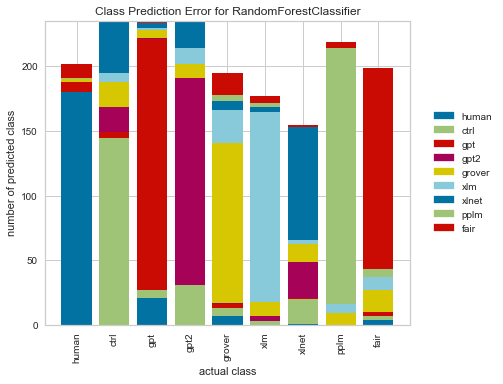

              precision    recall  f1-score   support

        ctrl     0.8911    0.8451    0.8675       213
         gpt     0.8017    0.9108    0.8527       213
        gpt2     0.5776    0.7477    0.6517       214
      grover     0.6359    0.5822    0.6078       213
         xlm     0.9041    0.9296    0.9167       213
       xlnet     0.7839    0.7324    0.7573       213
        pplm     0.5613    0.4065    0.4715       214
       human     0.8305    0.6901    0.7538       213
        fair     0.5731    0.6808    0.6223       213

    accuracy                         0.7249      1919
   macro avg     0.7288    0.7250    0.7224      1919
weighted avg     0.7286    0.7249    0.7222      1919

confusion matrix:  [0.84507042 0.91079812 0.74766355 0.58215962 0.92957746 0.73239437
 0.40654206 0.69014085 0.68075117]
Accuracy: 0.7248566961959354
Recall:  0.7250108473617753
Precision:  0.7288008088580441
F1: 0.7223831240378793


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

In [249]:
classify(data = collapsed.fillna(0), label=data['class'])

C:\Users\Adaku\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


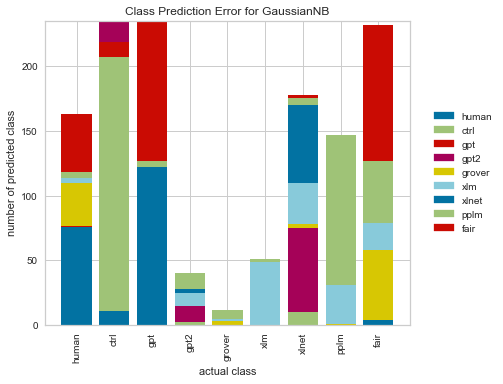

              precision    recall  f1-score   support

        ctrl     0.4663    0.3568    0.4043       213
         gpt     0.4843    0.9390    0.6390       213
        gpt2     0.3250    0.0607    0.1024       214
      grover     0.2500    0.0141    0.0267       213
         xlm     0.7891    0.5446    0.6444       213
       xlnet     0.4526    0.4930    0.4719       213
        pplm     0.3371    0.2804    0.3061       214
       human     0.9608    0.2300    0.3712       213
        fair     0.2870    0.9202    0.4375       213

    accuracy                         0.4263      1919
   macro avg     0.4836    0.4265    0.3782      1919
weighted avg     0.4834    0.4263    0.3780      1919

confusion matrix:  [0.35680751 0.93896714 0.06074766 0.01408451 0.54460094 0.49295775
 0.28037383 0.23004695 0.92018779]
Accuracy: 0.42626367899947887
Recall:  0.42653045305408077
Precision:  0.48356147130917093
F1: 0.37816121703538536


GaussianNB(priors=None, var_smoothing=1e-09)

In [247]:
classify(data = collapsed.fillna(0), label=data['class'])

# Keywords

In [170]:
from rake_nltk import Rake
import operator
from sklearn.naive_bayes import GaussianNB



In [178]:
r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

keywords = []
for i in data['text']:
    r.extract_keywords_from_text(i)
    keywords.append(r.get_ranked_phrases())
    

In [184]:
keywords[1:2]

[['2009 sunday 22 le 20 november 26 h e cest un el 19 december 12 mar 2004 au 24 2001',
  'top city official warns american express newspaper le monde today article reporting wednesday may 16 march 16',
  '2 la primera ber c en lundi g uire sd paris anl nterme',
  'government says public reaction seems like saying government response appears slow',
  '2006 national security council release du 23 january 22',
  'scientists report finding signs pointing toward emergence next week',
  '2005 los angeles et al qaeda 17 september 23',
  'bloomberg reports swine flu crisis shows two days ago',
  'reported yesterday morning us govt ts de la',
  'years ago among pigs carrying highly contagious virus',
  'help stop spreading quickly enough time frame',
  'either one way -- another case confirms',
  'still investigating whether anyone else may',
  'unusual strain called sars could spread',
  'sides seem intent upon taking advantage',
  'health said tests showed evidence suggesting',
  'action mig

In [243]:
def classify(data, label):
    

    X_train, X_test, y_train, y_test = train_test_split(data, label, stratify = label, test_size = 0.2, random_state = 1234)
    
#     clf = RandomForestClassifier(random_state=1234,n_estimators=150,n_jobs=-1)
    clf = LogisticRegression(solver = 'lbfgs', multi_class='auto')
    
    v = TfidfVectorizer()
    
    train_corpus = X_train
#     train_corpus = [[word.lower() for word in text.split()] for text in train_corpus]
    train_corpus = [" ".join(x) for x in train_corpus]


    test_corpus = X_test
    test_corpus = [" ".join(x) for x in test_corpus]

#     ax = axes.set_ylim([0,300])
    train_corpus = v.fit_transform(train_corpus)
    test_corpus = v.transform(test_corpus)
    
    fit = clf.fit(train_corpus,y_train)
    pred = clf.predict(test_corpus)
    
    # Instantiate the classification model and visualizer
    visualizer = ClassPredictionError(clf, classes= ['human', 'ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'fair'])

    # Fit the training data to the visualizer
    visualizer.fit(train_corpus, y_train)

    # Evaluate the model on the test data
    visualizer.score(test_corpus, y_test)

    # Draw visualization
    visualizer.show()
    
    
    matrix = confusion_matrix(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair'])
    mat = matrix.diagonal()/matrix.sum(axis=1)
    print(classification_report(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover','xlm', 'xlnet', 'pplm', 'human', 'fair'], digits=4))
    print('confusion matrix: ', mat)
    
    Accuracy = accuracy_score(y_test,pred)
    F1 = f1_score(y_test, pred, average='macro')
    print("Accuracy:", Accuracy)
    
    rec = recall_score(y_test, pred, average='macro')
    print('Recall: ', rec)
    prec = precision_score(y_test, pred, average='macro')
    print('Precision: ', prec)
    
    print('F1:', F1)
    
    return clf, v

In [200]:
liwc = pd.read_csv('C:\\Users\\Adaku\\OneDrive - UMBC\\Authorship Attribution\\Clean_Generated\\Stylistic\\LIWC2015 Results.csv')
uid = pd.read_csv('C:\\Users\\Adaku\\OneDrive - UMBC\\Authorship Attribution\\Clean_Generated\\Stylistic\\UID.csv')

In [201]:
liwc = liwc.drop(columns = ['A', 'B', 'C'])
uid = uid.drop(columns = 'Text', axis=0)

In [202]:
combine = pd.concat([uid, liwc], axis=1, sort=True)
combine = combine.drop(columns =  ['Unnamed: 0'])

In [203]:
label = []

for i in combine['Filename']:
    if i == 'new_ctrl.csv':
        label.append('ctrl')
    elif i == 'new_gpt.csv':
        label.append('gpt')
    elif i == 'new_gpt2.csv':
        label.append('gpt2')
    elif i == 'new_grover.csv':
        label.append('grover')
    elif i == 'new_xlm.csv':
        label.append('xlm')
    elif i == 'new_xlnet.csv':
        label.append('xlnet')
    elif i == 'new_pplm.csv':
        label.append('pplm')
    elif i == 'new_human.csv':
        label.append('human')
    elif i == 'new_fair.csv':
        label.append('fair')

In [204]:
Filename = combine['Filename']
combine = combine.drop(columns =  ['Filename'])

In [221]:
new_keywords = []

for i in keywords:
    new_keywords.append(" ".join(i))

In [224]:
combine['keywords'] = new_keywords

In [225]:
combine.head()

,UID,Flesch Reading Ease,Flesch-Kincaid,Fog Scale,SMOG Index,Automated Readability Index,Coleman-Liau Index,Linsear Write Formula,Dale-Chall Readability Score,WC,...,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,keywords
0,9.0,45.172917,11.845833,12.394583,0.0,14.341667,14.3775,12.375,8.346667,475,...,0.21,0.21,0.42,0.21,0.21,1.05,0.84,0.42,0.21,friend called ms word office pc 8 +; aol mail ...
1,9.0,45.521200,11.700000,12.016000,0.0,13.972000,13.1584,12.180,8.463200,483,...,0.41,0.21,0.21,0.21,0.21,0.41,0.41,0.41,0.21,2009 sunday 22 le 20 november 26 h e cest un e...
2,9.0,63.118400,9.236000,10.264400,0.0,11.060000,10.1776,11.440,6.477600,483,...,0.00,0.21,0.21,0.21,0.21,0.62,0.41,0.21,0.21,australia mexico vietnam philippines canada br...
3,9.0,46.265200,11.748000,12.496000,0.0,14.224000,14.2600,12.840,7.620400,498,...,0.20,0.20,0.80,0.20,0.20,0.00,0.20,0.00,0.20,2017 10 november 25 september 11 years later l...
4,9.0,76.644500,7.425000,9.033500,0.0,7.300000,5.5955,10.550,4.569500,392,...,0.26,0.26,1.02,2.55,0.77,0.77,1.02,0.51,0.26,2 billion dollars per capita rate rose sharply...


In [238]:
combine.shape

(9594, 103)

C:\Users\Adaku\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Adaku\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


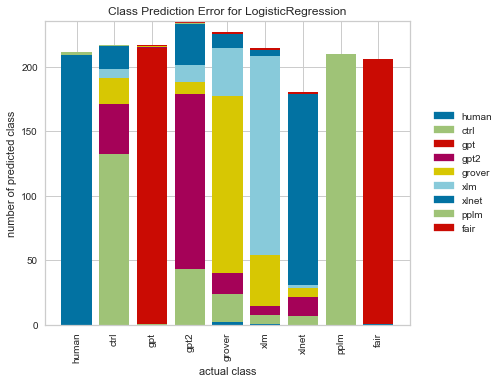

              precision    recall  f1-score   support

        ctrl     0.9905    0.9812    0.9858       213
         gpt     0.9816    1.0000    0.9907       213
        gpt2     0.5738    0.6355    0.6031       214
      grover     0.6035    0.6432    0.6227       213
         xlm     1.0000    0.9859    0.9929       213
       xlnet     0.9951    0.9624    0.9785       213
        pplm     0.8222    0.6916    0.7513       214
       human     0.7196    0.7230    0.7213       213
        fair     0.6083    0.6197    0.6140       213

    accuracy                         0.8046      1919
   macro avg     0.8105    0.8047    0.8067      1919
weighted avg     0.8104    0.8046    0.8066      1919

confusion matrix:  [0.98122066 1.         0.63551402 0.64319249 0.98591549 0.96244131
 0.69158879 0.72300469 0.61971831]
Accuracy: 0.8045857217300677
Recall:  0.8047328623871997
Precision:  0.8105267768003246
F1: 0.8067044781932784


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

In [244]:
classify(data = keywords, label = data['class'])

In [120]:
import grammar_check
tool = grammar_check.LanguageTool('en-GB')
text = 'This are bad.'
matches = tool.check(text)

ModuleNotFoundError: No module named 'grammar_check'

In [126]:
import language_check
tool = language_check.LanguageTool('en-US')
text = u'A sentence with a error in the Hitchhiker’s Guide tot he Galaxy'
matches = tool.check(text)
len(matches)

2

In [134]:
matches

[Match({'fromy': 0, 'fromx': 16, 'toy': 0, 'tox': 17, 'ruleId': 'EN_A_VS_AN', 'msg': "Use 'an' instead of 'a' if the following word starts with a vowel sound, e.g. 'an article', 'an hour'", 'replacements': ['an'], 'context': 'A sentence with a error in the Hitchhiker’s Guide tot he ...', 'contextoffset': 16, 'offset': 16, 'errorlength': 1, 'category': 'Miscellaneous', 'locqualityissuetype': 'misspelling'}),
 Match({'fromy': 0, 'fromx': 50, 'toy': 0, 'tox': 56, 'ruleId': 'TOT_HE', 'subId': '1', 'msg': "Did you mean 'to the'?", 'replacements': ['to the'], 'context': '... with a error in the Hitchhiker’s Guide tot he Galaxy', 'contextoffset': 43, 'offset': 50, 'errorlength': 6, 'category': 'Possible Typo', 'locqualityissuetype': 'misspelling'})]

In [136]:
language_check.correct(text, matches)

'A sentence with an error in the Hitchhiker’s Guide to the Galaxy'

In [139]:
def get_gen(name):
    token_word = []
    gen = data[data['class'] == name]['text']
    
    for i in gen:
        token_word.append(sent_tokenize(i))
    
    return token_word

In [140]:
gpt = get_gen('gpt')

In [164]:
len(gpt[1][1])*len(gpt_error)

7178112

In [146]:
def error_count(text):
    error = []
    for i in text:
        for j in i:
            matches = tool.check(j)
            error.append(len(matches))
    return error

In [147]:
gpt_error = error_count(gpt)

In [167]:
sum(gpt_error)/(len(gpt[1][1])*len(gpt_error)) * 100

1.3879972895379733

In [151]:
gpt_error[2]

5

In [153]:
ctrl = get_gen('ctrl')
ctrl_error = error_count(ctrl)

In [170]:
sum(ctrl_error)/(len(ctrl[1][1])*len(ctrl_error)) * 100

2.117109525961343

In [155]:
xlm = get_gen('xlm')
xlm_error = error_count(xlm)
sum(xlm_error)/len(xlm_error)

11.473374175306315

In [180]:
xlm[1][5]

'accidents dammit -helpless although already as soon sad dead eh great better alas somebody times twice?+- accident illness either painfully whatever born lives old unhappy anybody deaths awhile alike later elderly eternal with ordinarily middle-aged babies alive happily nobody murdered by accidentally young suicide older oldc orphan birth ill orphans killed wellperagaingone "sudden killing indeed forgotten unmorestillbirths sick fatal homeless newborn revenge nevernew finally fucking bloody weird murder happy wars unlikely who normal crying murders violent violence mourning mad dangerous end sleeping bankrupt madness rich hell game tragedy refuck stupid insane going fights angry alone slaughter wrong fear unfair guilty short nervous calm backwards dad none unexpected down emotions losing kill fair depression defect glad kills mood killings sleep vengeance sabotage lucky useless brave frightened cheating hate apart stealing remorse bond sane war meat nasty winning scared funeral guilt 

In [182]:
sum(xlm_error)/(len(xlm[1][1])*len(xlm_error)) * 100

14.709454070905531

In [156]:
xlnet = get_gen('xlnet')
xlnet_error = error_count(xlnet)
sum(xlnet_error)/len(xlnet_error)

6.679716629381059

In [172]:
sum(xlnet_error)/(len(xlnet[1][1]) * len(xlnet_error)) * 100

0.6173490415324454

In [157]:
gpt2 = get_gen('gpt2')
gpt2_error = error_count(gpt2)
sum(gpt2_error)/len(gpt2_error)

2.8698208915024463

In [173]:
sum(gpt2_error)/(len(gpt2[1][1]) * len(gpt2_error)) * 100

1.6032518946941041

In [159]:
pplm = get_gen('pplm')
pplm_error = error_count(pplm)
sum(pplm_error)/len(pplm_error)

8.336270555383184

In [174]:
sum(pplm_error)/(len(pplm[1][1]) * len(pplm_error)) * 100

2.654863234198466

In [160]:
grover = get_gen('grover')
grover_error = error_count(grover)
sum(grover_error)/len(grover_error)

3.256856696107848

In [175]:
sum(grover_error)/(len(grover[1][1]) * len(grover_error)) * 100

1.2872951368015209

In [161]:
fair = get_gen('fair')
fair_error = error_count(fair)
sum(fair_error)/len(fair_error)

0.8318343722172752

In [176]:
sum(fair_error)/(len(grover[1][1]) * len(fair_error)) * 100

0.3287882894139428

In [162]:
human = get_gen('human')
human_error = error_count(human)
sum(human_error)/len(human_error)

3.0528921255857955

In [177]:
sum(human_error)/(len(human[1][1]) * len(human_error)) * 100

1.1652260021319831